In [1]:
#Importing the usual libraries.
import numpy as np
import tensorly as tl
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.io import loadmat

#Setting style options.
sns.set()
np.set_printoptions(1)
from IPython.display import display, HTML

CSS = """
.output {
    align-items: center;
}

div.output_area {
    width: 55%;
}

"""

HTML('<style>{}</style>'.format(CSS))

Using numpy backend.


The following packages are used in this notebook:

- `numpy 1.18.1`
- `tensorly 0.4.3`
- `seaborn 0.10.0`

# Least Squares Kronecker Product Factorization (LSKronF)

Generate $\mathbf{X} = \mathbf{A}\otimes \mathbf{B} \in \mathbb{C}^{24 \times 6}$, for randomly chosen $\mathbf{A} \in \mathbb{C}^{4 \times 2}$ and $\mathbf{B} \in \mathbb{C}^{6 \times 3}$. Then, implement the Least-Squares Khatri-Rao Factorization (LSKRF) algorithm that estimate $\mathbf{A}$ and $\mathbf{B}$ by solving the following problem:

\begin{equation}
    (\hat{\mathbf{A}},\hat{\mathbf{B}}) = \underset{\mathbf{A},\mathbf{B}}{min} ||\mathbf{X} - \mathbf{A} \otimes \mathbf{B}|| ^{2}_{F}
\end{equation}

Compare the estimated matrices $\hat{\mathbf{A}}$ and $\hat{\mathbf{B}}$ with the original ones. What can you conclude? Explain the results.

Hint: Use the file “kronf_matrix.mat” to validate your result.

<font color='red'>Solution:</font>

In [2]:
#This function will reorganized a matrix X as needed to the computation of LSKronF.
def extract_chunk(X, shape_a, shape_b):
    shape_a = np.array(shape_a)
    shape_b = np.array(shape_b)    
    ratio = int(X.shape[1]/shape_b[1])
    chunks = np.split(X, ratio, axis=1)

    tensor = np.array(chunks).reshape(shape_a.prod(), shape_b[0], shape_b[1])
    
    X_approx = np.zeros([shape_b.prod(), shape_a.prod()],dtype = 'complex')
    for s in range(shape_a.prod()):
        X_approx[:,s] = tensor[s].flatten(order='F')
    
    return X_approx

In [3]:
#In this cell a function for LSKronF will be created.
def LSKronF(X,I,P,J,Q):
    #X: The uncorrupted signal X = A ⊗ B ∈ C^{IJ×PQ}, where A ∈ C^{I×P} and B ∈ C^{J×Q}.
    #(I,P,J,Q): Dimensions of A and B as mentioned above.
    
    #This line will call a function to construct the new matrix X
    #as X_approx = vec(B)vec(A)^T that will be used in the next computations.
    X_approx = extract_chunk(X,[I,P],[J,Q])
    #Obs:Is worth note that, except for the dimensions of A and B, the previously knowledge of the data
    #in A and B are obviously unknow.
    
    #In this line the SVD of the new matrix will be calculated.
    [U_p,S_p,V_p] = np.linalg.svd(X_approx)
    
    #Now the stimations of vec(A) and vec(B) will be made.
    A_hat = (np.sqrt(S_p[0])*((V_p[0,:])))[:,None]
    B_hat = (np.sqrt(S_p[0])*U_p[:,0])[:,None]
    
    #And here the unvec operation is made to obtain the final stimations of A and B.
    A_hat = A_hat.reshape(I,P,order = 'F')
    B_hat = B_hat.reshape(J,Q,order = 'F')
   
    X_hat = tl.tenalg.kronecker([A_hat,B_hat])
    
    #This line will calculate the Normalized Mean Square Error between the stimation X_hat and the know signal X.
    nmse  = (np.linalg.norm(X - X_hat))**2/(np.linalg.norm(X))**2
    
    return X_hat,nmse

# Test with (I,P,J,Q) = (4,2,6,3)

In [4]:
I,P,J,Q = 4,2,6,3
A = np.random.randn(I,P) + 1j*np.random.randn(I,P)
B = np.random.randn(J,Q) + 1j*np.random.randn(J,Q)
X = tl.tenalg.kronecker([A,B])
print('Transmited Signal X:')
print(X)

Transmited Signal X:
[[-0.3+5.8e-02j  0.1+1.7e-03j  1.8-1.1e-01j  0.2+1.4e-01j -0.1-6.7e-02j
  -0.9-9.6e-01j]
 [-0.6+6.6e-01j  0. -3.5e-01j -0.1+1.1e+00j  0.7+4.8e-02j -0.2+1.4e-01j
   0.7-4.1e-01j]
 [ 1.3-1.7e-01j -1. +7.0e-01j  1.5+1.4e-01j -0.7-6.5e-01j  0.9+2.6e-01j
  -0.6-9.1e-01j]
 [ 0.6-1.0e-02j  0.4-2.1e-01j -0.5+1.1e+00j -0.3-3.2e-01j -0.3-1.3e-01j
   0.9-2.3e-01j]
 [-0.3+2.0e-01j  0.1+6.3e-01j  0.2+3.2e-01j  0.3+7.6e-02j  0.3-3.4e-01j
   0.1-2.8e-01j]
 [ 0.5+4.8e-01j -0.7+7.4e-01j  0.1-5.6e-01j  0. -5.3e-01j  0.7+6.1e-02j
  -0.3+2.2e-01j]
 [ 0.4+5.4e-01j -0.1-2.4e-01j -1.7-3.5e+00j -0.3-2.8e-01j  0.1+1.3e-01j
   1.5+1.9e+00j]
 [ 1.9+7.1e-01j -0.7+2.3e-01j  2.3-5.9e-01j -1.2-1.8e-01j  0.4-2.3e-01j
  -1.3+6.6e-01j]
 [-1.4-2.5e+00j  2.3+1.5e+00j -0.9-3.1e+00j  1.2+1.3e+00j -1.6-6.0e-01j
   1. +1.8e+00j]
 [-0.5-1.2e+00j -0.8-6.5e-01j  2.8+1.2e-01j  0.4+6.3e-01j  0.5+2.9e-01j
  -1.7+2.9e-01j]
 [ 0.7+4.3e-01j  1.2-7.1e-01j  0.5-7.2e-01j -0.4-1.8e-01j -0.6+5.8e-01j
  -0.2+5.0e-01j]


In [5]:
[X_hat,nmse] = LSKronF(X,I,P,J,Q)
print('Normalized Mean Square Error:')
print(nmse)
print('Stimated Signal X:')
print(X_hat)

Normalized Mean Square Error:
1.7850472867776424e-31
Stimated Signal X:
[[-0.3+5.8e-02j  0.1+1.7e-03j  1.8-1.1e-01j  0.2+1.4e-01j -0.1-6.7e-02j
  -0.9-9.6e-01j]
 [-0.6+6.6e-01j  0. -3.5e-01j -0.1+1.1e+00j  0.7+4.8e-02j -0.2+1.4e-01j
   0.7-4.1e-01j]
 [ 1.3-1.7e-01j -1. +7.0e-01j  1.5+1.4e-01j -0.7-6.5e-01j  0.9+2.6e-01j
  -0.6-9.1e-01j]
 [ 0.6-1.0e-02j  0.4-2.1e-01j -0.5+1.1e+00j -0.3-3.2e-01j -0.3-1.3e-01j
   0.9-2.3e-01j]
 [-0.3+2.0e-01j  0.1+6.3e-01j  0.2+3.2e-01j  0.3+7.6e-02j  0.3-3.4e-01j
   0.1-2.8e-01j]
 [ 0.5+4.8e-01j -0.7+7.4e-01j  0.1-5.6e-01j  0. -5.3e-01j  0.7+6.1e-02j
  -0.3+2.2e-01j]
 [ 0.4+5.4e-01j -0.1-2.4e-01j -1.7-3.5e+00j -0.3-2.8e-01j  0.1+1.3e-01j
   1.5+1.9e+00j]
 [ 1.9+7.1e-01j -0.7+2.3e-01j  2.3-5.9e-01j -1.2-1.8e-01j  0.4-2.3e-01j
  -1.3+6.6e-01j]
 [-1.4-2.5e+00j  2.3+1.5e+00j -0.9-3.1e+00j  1.2+1.3e+00j -1.6-6.0e-01j
   1. +1.8e+00j]
 [-0.5-1.2e+00j -0.8-6.5e-01j  2.8+1.2e-01j  0.4+6.3e-01j  0.5+2.9e-01j
  -1.7+2.9e-01j]
 [ 0.7+4.3e-01j  1.2-7.1e-01j  0.5-7.2

# Test with kronf_matrix.mat

In [6]:
#Is possible to load the .mat directly in the workspace, but some pre-processing will be needed to correctly since the received .mat file
#is based on fortran language.
#So to make things easier for now A and B presented in the .mat file are redefined bellow as a python array.

A = np.array([[ 1.521, -2.14 ,  0.056],
              [-1.175,  2.987,  0.247],
              [ 0.139, -0.958, -0.15 ],
              [-0.462, -0.177, -0.193]])

B = np.array([[ 1.118, -2.518],
              [ 0.442,  0.429],
              [-0.046,  0.496],
              [ 0.589, -0.449]])

#Construction of the X signal.
X = tl.tenalg.kronecker([A,B])

In [7]:
[X_hat,nmse] = LSKronF(X,4,3,4,2)

In [8]:
print('Know:')
print(X)
print('Stimated:')
print(np.real(X_hat))
print('NMSE:')
print(nmse)

Know:
[[ 1.7e+00 -3.8e+00 -2.4e+00  5.4e+00  6.3e-02 -1.4e-01]
 [ 6.7e-01  6.5e-01 -9.5e-01 -9.2e-01  2.5e-02  2.4e-02]
 [-7.0e-02  7.5e-01  9.8e-02 -1.1e+00 -2.6e-03  2.8e-02]
 [ 9.0e-01 -6.8e-01 -1.3e+00  9.6e-01  3.3e-02 -2.5e-02]
 [-1.3e+00  3.0e+00  3.3e+00 -7.5e+00  2.8e-01 -6.2e-01]
 [-5.2e-01 -5.0e-01  1.3e+00  1.3e+00  1.1e-01  1.1e-01]
 [ 5.4e-02 -5.8e-01 -1.4e-01  1.5e+00 -1.1e-02  1.2e-01]
 [-6.9e-01  5.3e-01  1.8e+00 -1.3e+00  1.5e-01 -1.1e-01]
 [ 1.6e-01 -3.5e-01 -1.1e+00  2.4e+00 -1.7e-01  3.8e-01]
 [ 6.1e-02  6.0e-02 -4.2e-01 -4.1e-01 -6.6e-02 -6.4e-02]
 [-6.4e-03  6.9e-02  4.4e-02 -4.8e-01  6.9e-03 -7.4e-02]
 [ 8.2e-02 -6.2e-02 -5.6e-01  4.3e-01 -8.8e-02  6.7e-02]
 [-5.2e-01  1.2e+00 -2.0e-01  4.5e-01 -2.2e-01  4.9e-01]
 [-2.0e-01 -2.0e-01 -7.8e-02 -7.6e-02 -8.5e-02 -8.3e-02]
 [ 2.1e-02 -2.3e-01  8.1e-03 -8.8e-02  8.9e-03 -9.6e-02]
 [-2.7e-01  2.1e-01 -1.0e-01  7.9e-02 -1.1e-01  8.7e-02]]
Stimated:
[[ 1.7e+00 -3.8e+00 -2.4e+00  5.4e+00  6.3e-02 -1.4e-01]
 [ 6.7e-01  6.

So as we can see the stimation of the signal X can be considered perfect under the LSKronF Algorithm in a ideal scenario where the signal isn't corrupted by any kind of noise. It's also worth note that the individual stimations of A and B are considerably inaccurate but their $\otimes$ product precisaly create a stimation of the signal X. This occurs because the operation of multiplication between scalars are not unique, as already seen in the previously homework.

# Monte Carlo Experiments 

Assuming 1000 Monte Carlo experiments, generate  $\mathbf{X_{0}} = \mathbf{A} \otimes \mathbf{B} \in \mathbb{C}^{IJ \times PQ}$, for randomly chosen $\mathbf{A} \in \mathbb{C}^{I \times P}$ and $\mathbf{B} \in \mathbb{C}^{J \times Q}$, whose elements are drawn from a normal distribution. Let $\mathbf{X} = \mathbf{X_{0}} + \alpha \mathbf{V}$ be a noisy version of $\mathbf{X_{0}}$ where $\mathbf{V}$ is the additive noise term, whose elements are drawn from a normal distribution. The parameter $\alpha$ controls the power (variance) of the noise term, and is defined as a function of the signal to noise ratio (SNR), in dB, as follows:

\begin{equation}
    SNR_{dB} = 10 \log_{10} \frac{||\mathbf{X_{0}}||^{2}_{F}}{||\alpha \mathbf{V}||^{2}_{F}}
\end{equation}

Assuming the SNR range $[0, 5, 10, 15, 20, 25, 30]$ dB, find the estimates $\hat{\mathbf{A}}$ and $\hat{\mathbf{B}}$ obtained with the LSKRF algorithm for the configurations $(I, J) = (2, 4),(P,Q) = (3,5)$ and $(I,J) = (4,8),(P, Q) = (3, 5)$. Let us define the normalized mean square error (NMSE) measure as follows:

\begin{equation}
    NMSE(\mathbf{X_{0}}) = \frac{1}{1000} \sum^{1000}_{i = 1} \frac{||\hat{\mathbf{X_{0}(i)}} - \mathbf{X_{0}(i)}||^{2}_{F}}{||\mathbf{X_{0}(i)}||^{2}_{F}}
\end{equation}

where $\mathbf{X_{0}(i)}$ and $\hat{\mathbf{X_{0}(i)}}$ represent the original data matrix and the reconstructed one at the ith experiment, respectively. For each SNR value and configuration, plot the NMSE vs. SNR curve. Discuss the obtained results.

<font color='red'>Solution:</font>

In [2]:
def LSKronF_montecarlo(X_0,I,P,J,Q,SNR_dB):
    #X_0: The uncorrupted signal X = A ⊗ B ∈ C^{IJ×PQ}, where A ∈ C^{I×P} and B ∈ C^{J×Q}.
    #(I,P,J,Q): Dimensions of A and B as mentioned above.
    #SNR_dB: A vector of SNR values in decibels.
    
    #Obtaining the size of the array SNR_db
    Size = len(SNR_dB)
    #Creating an array to alocate the values of NMSE per run.
    NMSE = np.zeros(Size)
    
    #This loop controls the number of runs in the Monte Carlo simulation.
    for k in range(0,1000):
        
        #Creating the noise array.
        V = np.random.normal(0,1,[I*J,P*Q]) + 1j*np.random.normal(0,1,[I*J,P*Q])
        
        #This loop will run through the SNR_db vector.
        for i in range(0,Size):
            
            #Converting the SNR that it is in dB to the linear scale.
            SNR_Linear = 10**(SNR_dB[i]/10)
            
            #The process to obtain the value of alpha that will adjust the noise to the desirable value of SNR.
            alphaV = ((np.linalg.norm(X_0,'fro'))**2)/SNR_Linear
            alpha = np.sqrt(alphaV/((np.linalg.norm(V,'fro'))**2))
            
            #Adding the desirable noise to the original signal X_0.
            X = X_0 + alpha*V
            [_,nmse] = LSKronF(X,I,P,J,Q)
           
            #Obtaining the NMSE for the k-th run of the MCS at the SNR_dB[i].
            NMSE[i] = NMSE[i] + nmse
    
    #Obtaining the mean of all the runs.
    NMSE = NMSE/1000
    
    return NMSE

Bellow the asked configurations are generated:

In [10]:
I,P,J,Q = 2,3,4,5
SNR_dB = [0,5,10,15,20,25,30]
A = np.random.randn(I,P) 
B = np.random.randn(J,Q)
X_0 = tl.tenalg.kronecker([A,B])

In [11]:
NMSE1 = LSKronF_montecarlo(X_0,I,P,J,Q,SNR_dB)

In [12]:
I,P,J,Q = 4,3,8,5
SNR_dB = [0,5,10,15,20,25,30]
A = np.random.randn(I,P) 
B = np.random.randn(J,Q)
X_0 = tl.tenalg.kronecker([A,B])

In [13]:
NMSE2 = LSKronF_montecarlo(X_0,I,P,J,Q,SNR_dB)

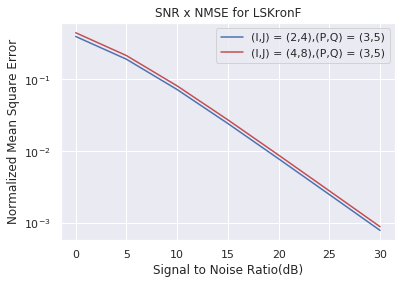

In [14]:
plt.figure()
plt.semilogy(SNR_dB,NMSE1,'b', label = '(I,J) = (2,4),(P,Q) = (3,5)')
plt.semilogy(SNR_dB,NMSE2,'r', label = '(I,J) = (4,8),(P,Q) = (3,5)')
plt.title('SNR x NMSE for LSKronF')
plt.xlabel('Signal to Noise Ratio(dB)')
plt.ylabel('Normalized Mean Square Error')
plt.legend()
plt.show()

As expected at low values of SNR the noise is so strong that the stimated signal is almost completely diferent from the transmited signal. However as the SNR value increase the NMSE values quickly reduce to zero before his maximum value at 30dB. Also is worth note that the change of scenario of (I,J,P,Q) = (2,4,3,5) to (I,J,P,Q) = (4,8,3,5) praticaly didn't change the NMSE values.

## About this notebook

**Author**: Kenneth B. dos A. Benício

**Uptaded on**: 2020-03-30